In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation

# Specify whether or not to save figures
save_figures = False

**Orthogonal matix** $Q^T=Q^{-1}$. 
QR decomposition of matrix $A$: $A=QR$ where Q is orthogonal and R is upper tiangular. Any real square matix $A$ can be QR decomposed.<br>
**Unitary matrix** $U^*U=I$<br>
**SVD decomposition**: $M = U \Sigma V^*$ of M [m x n] matrix. $U$ is an m × m unitary matrix (orthogonal matrix if M is real)<br>
**Hermitian matrix**: complex square matrix that is equal to its own conjugate transpose $A=A^H$<br>
**Cholesky decomposition**: is a decomposition of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose. $A=LL^H$<br>

In [2]:
# Set the parameters of the HMM
T = 200    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an LDS with the somewhat interesting dynamics parameters
true_lds = ssm.LDS(N, D, emissions="gaussian")
A0 = .99 * random_rotation(D, theta=np.pi/20)
# S = (1 + 3 * npr.rand(D))
S = np.arange(1, D+1)
R = np.linalg.svd(npr.randn(D, D))[0] * S
A = R.dot(A0).dot(np.linalg.inv(R))
b = npr.randn(D)
true_lds.dynamics.As[0] = A
true_lds.dynamics.bs[0] = b
_, x, y = true_lds.sample(T)

$A0 = \begin{matrix} cos(\theta) & sin(\theta) \\ -sin(\theta) & cos(\theta) \end{matrix}$<br>
$x$ is (200,2); $y$ is (200,10). Were sampled from an LDS, need to understand how.<br>

$As$ was cleaverly created; $bs$ is random.
### sample function
 $z$ stores the switching variable, it is an *int*<br>x stores the latent state-vector<br>y stores the observations<br>
 **sample_x** function uses the matrices saved within the object: D, As, bs, Vs = self.D, self.As, self.bs, self.Vs<br>
 Here we have a single LDS so $z=0$ for all time-tags. The object stores $\Sigma_{init},\mu_{init}$ from which $x[0]$ is created: $x[0]=\mu_{init} + S \cdot N(0,I)$ where $S$ is the Cholesky decomposition of the covariance matirx $\Sigma_{init} = SS^H$. <br> 
 
 For $x[t>0]$ the values of $x$ are sampled from an autoregressive distribution whose calculation is given: <br>
 $\mu[t] = bs + As \cdot x[t-1]$ **This is an affine transformation from x[t-1] to x[t]**<br>
 $x[t] = \mu[t] + S \cdot N(0,I)$; where $S$ is the Cholesky decomposition of the covariance matirx $\Sigma = SS^H$. **Process noise is added to the transformation**<br>
 
 After all $x$ values were created the observations $y$ are created using the function **sample**:<br>
 $Cs$ - a 10x2 matrix<br>
 $ds$ is a 1 x 10 vector <br>
 $\mu_s = Cs \cdot x + ds$ - a #time-tags x 10 matrix **This is an affine transformation from x with dim=2 to y with dim=10**<br>
 $etas = e^{\text{self.inv_etas}}$ self.inv_etas is a 1 x 10 vector <br>
 now, we take $etas$ and duplicate it to a matrix with number of rows as number of time-tags, each row is the same. let's call this matrix ETAS <br>
 we draw a matrix #time-tags x 10 from $N(0,1)$. Let's call it DR. we will multiply it entrie-wise with $\sqrt{ELAS}$.<br>
 $y = \mu_s + \sqrt{ETAS} * DR$ **Random measurement-noise is added to the transformation**
 
 

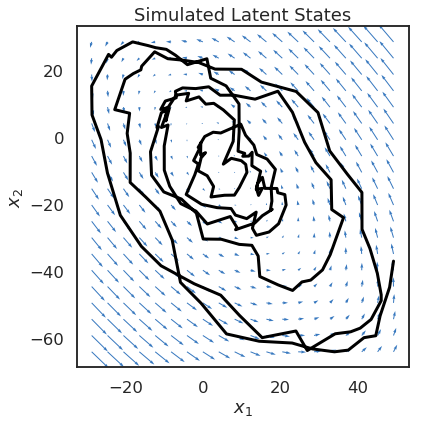

In [4]:
# Plot the dynamics vector field
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 20
true_lds.dynamics.As[0] = A
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))
XY = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
dx = XY.dot(A.T) + b - XY

plt.figure(figsize=(6, 6))
plt.quiver(XX, YY, dx[:,0], dx[:,1], color=colors[0])
plt.plot(x[:,0], x[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_1.pdf")

In [ ]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, N/D))

# Plot the continuous latent states
lim = abs(x).max()
plt.subplot(gs[0])
for d in range(D):
    plt.plot(x[:, d] + lim * d, '-k')
plt.yticks(np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xticks([])
plt.xlim(0, T)
plt.title("Simulated Latent States")

lim = abs(y).max()
plt.subplot(gs[1])
for n in range(N):
    plt.plot(y[:, n] - lim * n, '-k')
plt.yticks(-np.arange(N) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(N)])
plt.xlabel("time")
plt.xlim(0, T)

plt.title("Simulated Observations")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_2.pdf")

In [ ]:
print("Fitting LDS with Laplace-EM using structured variational posterior")
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(y)

q_lem_elbos, q_lem = lds.fit(y, method="laplace_em", variational_posterior="structured_meanfield", 
                             num_iters=10, initialize=False)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Smooth the data under the variational posterior
q_lem_y = lds.smooth(q_lem_x, y)

In [ ]:
print("Fitting LDS with SVI")

# Create the model and initialize its parameters
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(y)

# Create a variational posterior
q_mf_elbos, q_mf = lds.fit(y, method="bbvi", variational_posterior="mf", num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Smooth the data under the variational posterior
q_mf_y = lds.smooth(q_mf_x, y)

In [ ]:
print("Fitting LDS with SVI using structured variational posterior")
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(y)

q_struct_elbos, q_struct = lds.fit(y, method="bbvi", variational_posterior="tridiag", num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Smooth the data under the variational posterior
q_struct_y = lds.smooth(q_struct_x, y)

In [ ]:
# Plot the ELBOs
plt.plot(q_lem_elbos, label="Laplace-EM")
plt.plot(q_mf_elbos, label="MF")
plt.plot(q_struct_elbos, label="LDS")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(q_lem_x[:,d] + 4 * d, '--', color=colors[0], label="Laplace-EM" if d==0 else None)
    plt.plot(q_mf_x[:,d] + 4 * d, '--', color=colors[1], label="MF" if d==0 else None)
    plt.plot(q_struct_x[:,d] + 4 * d, ':', color=colors[2], label="Struct" if d==0 else None)
plt.ylabel("$x$")
plt.legend()

In [ ]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(y[:, n] + 4 * n, '-k', label="True" if n == 0 else None)
    plt.plot(q_lem_y[:, n] + 4 * n, '--', color=colors[0], label="Laplace-EM" if n == 0 else None)
    plt.plot(q_mf_y[:, n] + 4 * n, '--', color=colors[1], label="MF" if n == 0 else None)
    plt.plot(q_struct_y[:, n] + 4 * n, ':',  color=colors[2], label="Struct" if n == 0 else None)
plt.legend()
plt.xlabel("time")

# Fit an HMM to the LDS states

In [ ]:
N_iters = 50
K = 15
hmm = ssm.HMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(x, method="em", num_em_iters=N_iters)
z = hmm.most_likely_states(x)

In [ ]:
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

In [ ]:
# Plot the observation distributions
from hips.plotting.colormaps import white_to_color_cmap
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 100
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))

data = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = hmm.observations.log_likelihoods(data, input, mask, tag)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), 
                cmap=white_to_color_cmap(colors[k % len(colors)]))
    plt.plot(x[z==k, 0], x[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(x[:,0], x[:,1], '-k', lw=2, alpha=.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_3.pdf")


In [ ]:
# Simulate from the HMM fit
smpls = [hmm.sample(T-1, prefix=(z[:1], x[:1])) for _ in range(1)]

In [ ]:
plt.figure(figsize=(8, 6))
lim = abs(x).max()
for d in range(D):
    plt.plot(x[:,d] - d * lim, '-k', lw=4)
    for i, (_, x_smpl) in enumerate(smpls):
        x_smpl = np.concatenate((x[:1], x_smpl))
        plt.plot(x_smpl[:,d] - d*lim, '-', lw=1, color=colors[i])
        
plt.yticks(-np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xlabel("time")
plt.xlim(0, T)
plt.title("True LDS States and Fitted HMM Simulations")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_4.pdf")

In [ ]:
# Plot the observation distributions
from hips.plotting.colormaps import white_to_color_cmap
xmins = x.min(axis=0)
xmaxs = x.max(axis=0)
npts = 100
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))

data = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = hmm.observations.log_likelihoods(data, input, mask, tag)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), 
                cmap=white_to_color_cmap(colors[k % len(colors)]))
    plt.plot(x[z==k, 0], x[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(x[:,0], x[:,1], '-k', lw=2, alpha=.5)
for i, (_, x_smpl) in enumerate(smpls):
    x_smpl = np.concatenate((x[:1], x_smpl))
    plt.plot(x_smpl[:,0], x_smpl[:,1], '-', lw=1, color=colors[i])


plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

plt.tight_layout()

if save_figures:
    plt.savefig("lds_5.pdf")

# Simulate Poisson data from an Poisson LDS with the same dynamics

In [ ]:
import copy

plds = ssm.LDS(N, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(N)
_, x_plds, y_plds = plds.sample(T)


In [ ]:
# Plot the dynamics vector field
xmins = x_plds.min(axis=0)
xmaxs = x_plds.max(axis=0)
npts = 20
true_lds.dynamics.As[0] = A
XX, YY = np.meshgrid(np.linspace(xmins[0], xmaxs[0], npts), np.linspace(xmins[1], xmaxs[1], npts))
XY = np.column_stack((XX.ravel(), YY.ravel(), np.zeros((npts**2, D-2))))
dx = XY.dot(A.T) + b - XY

plt.figure(figsize=(6, 6))
plt.quiver(XX, YY, dx[:,0], dx[:,1], color=colors[0])
plt.plot(x_plds[:,0], x_plds[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_6.pdf")

In [ ]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, N/D))

# Plot the continuous latent states
lim = abs(x).max()
plt.subplot(gs[0])
for d in range(D):
    plt.plot(x[:, d] + lim * d, '-k')
plt.yticks(np.arange(D) * lim, ["$x_{}$".format(d+1) for d in range(D)])
plt.xticks([])
plt.xlim(0, T)
plt.title("Simulated Latent States")

lim = abs(y).max()
plt.subplot(gs[1])
plt.imshow(y_plds.T, cmap="Greys", aspect="auto")
plt.yticks(np.arange(N), ["$y_{{ {} }}$".format(n+1) for n in range(N)])
plt.xlabel("time")
plt.xlim(0, T)
plt.title("Simulated Poisson Observations")
plt.colorbar()

plt.tight_layout()

if save_figures:
    plt.savefig("lds_7.pdf")